# Replicating plots in [*Rangaraju et al.*](http://dx.doi.org/10.7554/eLife.08833).

Tong Shu Li

We demonstrate the capabilities of our drift plotting functions. To do so, we will try to replicate some figures from [*Rangaraju et al.*](http://dx.doi.org/10.7554/eLife.08833).

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append("..")

In [3]:
from src.plots import plot_p_val_heatmap
from src.plots import plot_drift
from src.plots import plot_multi_density
from src.plots import config_plot

from src.stats import calculate_percentile

from src.util import subset

In [4]:
%matplotlib inline

---

## Read the filtered transcriptome data:

In [5]:
sub = pd.read_csv("../data/PMID26623667/avg_annotated_cpm_values.tsv", sep = '\t')

In [6]:
sub.shape

(130548, 11)

In [7]:
sub.head()

,seqname,sample,value,day_harvested,drug_conc_uM,day_drug_added,youngref,trans_drift,drug,wormbaseid,gene_symbol
0,2RSSE.1,1,4.105727,1,0,1,4.105726,-0.012915,water,WBGene00007064,2RSSE.1
1,2RSSE.1,2,7.687213,3,0,1,4.105726,0.562429,water,WBGene00007064,2RSSE.1
2,2RSSE.1,3,7.220500,5,0,1,4.105726,0.562490,water,WBGene00007064,2RSSE.1
3,2RSSE.1,4,3.923197,10,0,1,4.105726,-0.049039,water,WBGene00007064,2RSSE.1
4,2RSSE.1,5,4.042023,3,50,1,4.105726,-0.030335,mianserin,WBGene00007064,2RSSE.1


---

## CPM distribution for all samples (subset)

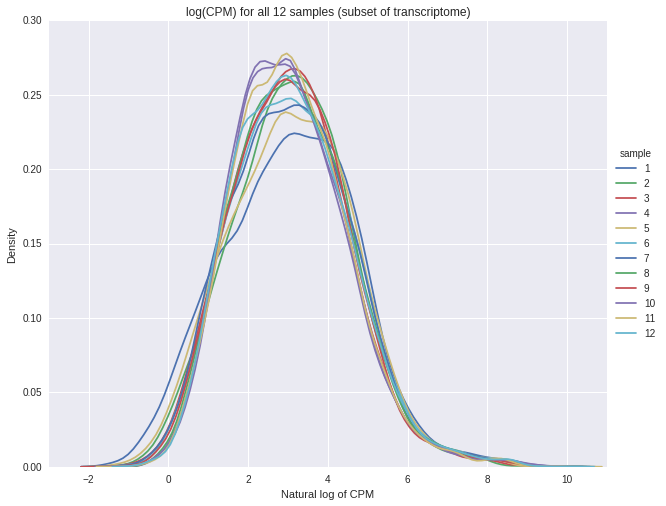

In [8]:
temp = sub.copy()
temp["log_value"] = np.log(temp["value"])

fig = plot_multi_density(
    temp, "sample", "log_value",
    rc = {"figure.figsize": (10, 8)}
)
fig.set_xlim((-3, 11))
fig.set_xlabel("Natural log of CPM")
fig.set_title("log(CPM) for all 12 samples (subset of transcriptome)");

The distribution of the CPM for the filtered subset looks much better, and is almost Gaussian (except for the tail to the right). We no longer see the hump at the far left.

## Drift distribution for subset of transcriptome

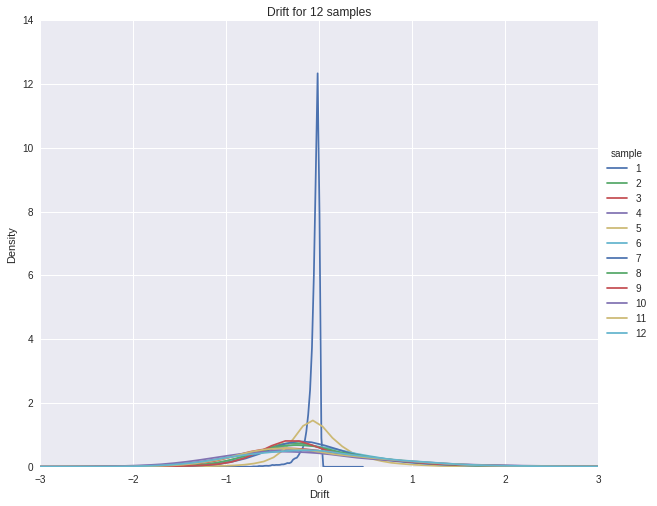

In [9]:
fig = plot_multi_density(
    sub, "sample", "trans_drift",
    rc = {"figure.figsize": (10, 8)}
)
fig.set_xlim((-3, 3))
fig.set_title("Drift for 12 samples")
fig.set_xlabel("Drift");

Sample 1 is skewing the plot:

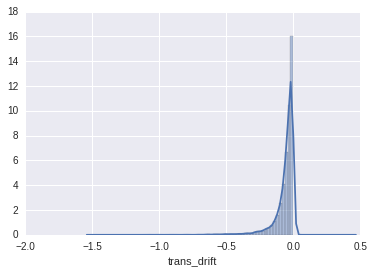

In [10]:
sns.distplot(sub.query("sample == 1")["trans_drift"]);

The first sample, by virtue of being the reference, has drift values which are not always exactly zero, but which is highly skewed. We will replot with sample 1 removed.

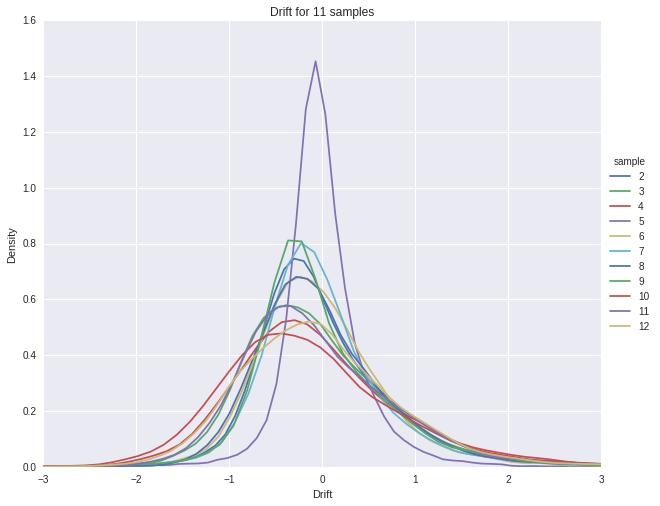

In [11]:
fig = plot_multi_density(
    sub.query("sample != 1"), "sample", "trans_drift",
    rc = {"figure.figsize": (10, 8)}
)
fig.set_xlim((-3, 3))
fig.set_title("Drift for 11 samples")
fig.set_xlabel("Drift");

Which sample has the high amount of density at zero drift?

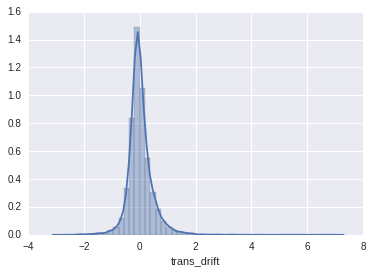

In [12]:
sns.distplot(sub.query("sample == 5")["trans_drift"]);

Again we see that sample 5 is giving us problems. It looks drastically different in drift than the other samples.

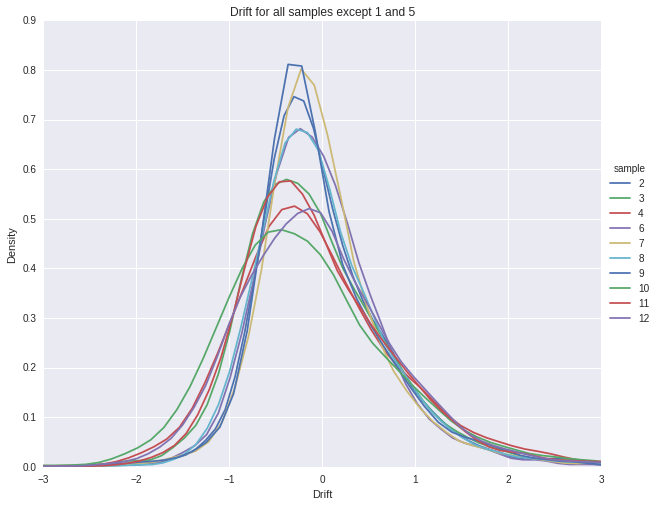

In [13]:
fig = plot_multi_density(
    sub.query("sample not in(1, 5)"), "sample", "trans_drift",
    rc = {"figure.figsize": (10, 8)}
)
fig.set_xlim((-3, 3))
fig.set_title("Drift for all samples except 1 and 5")
fig.set_xlabel("Drift");

The remaining samples still have a healthy amount of variation, but nothing as dramatic as that of sample 5.

---

## Drift stratified by expression decile (full transcriptome)

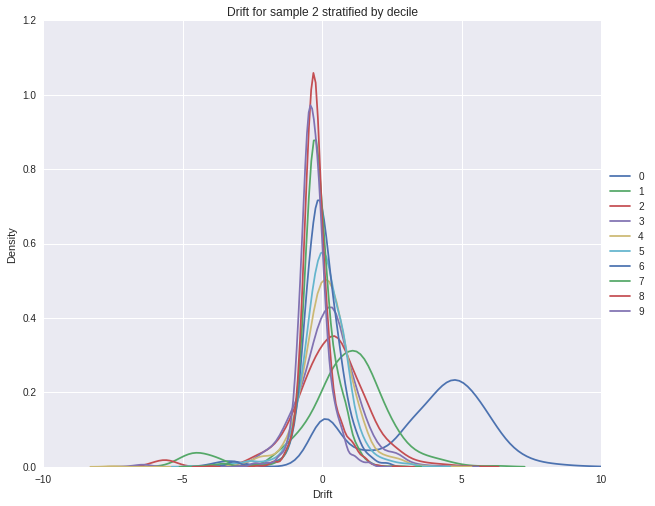

In [27]:
ax = plot_multi_density(
    full.query('sample == 2'), "decile", "drift",
    rc = {"figure.figsize": (10, 8)}
)
ax.set_xlim((-10, 10))
ax.set_title("Drift for sample 2 stratified by decile")
ax.set_xlabel("Drift")
ax.set_ylabel("Density")
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5));

We see here that for sample 2 the biggest changes in drift are being driven by the lowly expressed genes. The lowest decile of expressed genes drifts extremely largely to the right, since decreasing any more would result in zero expression.

## All samples, full transcriptome

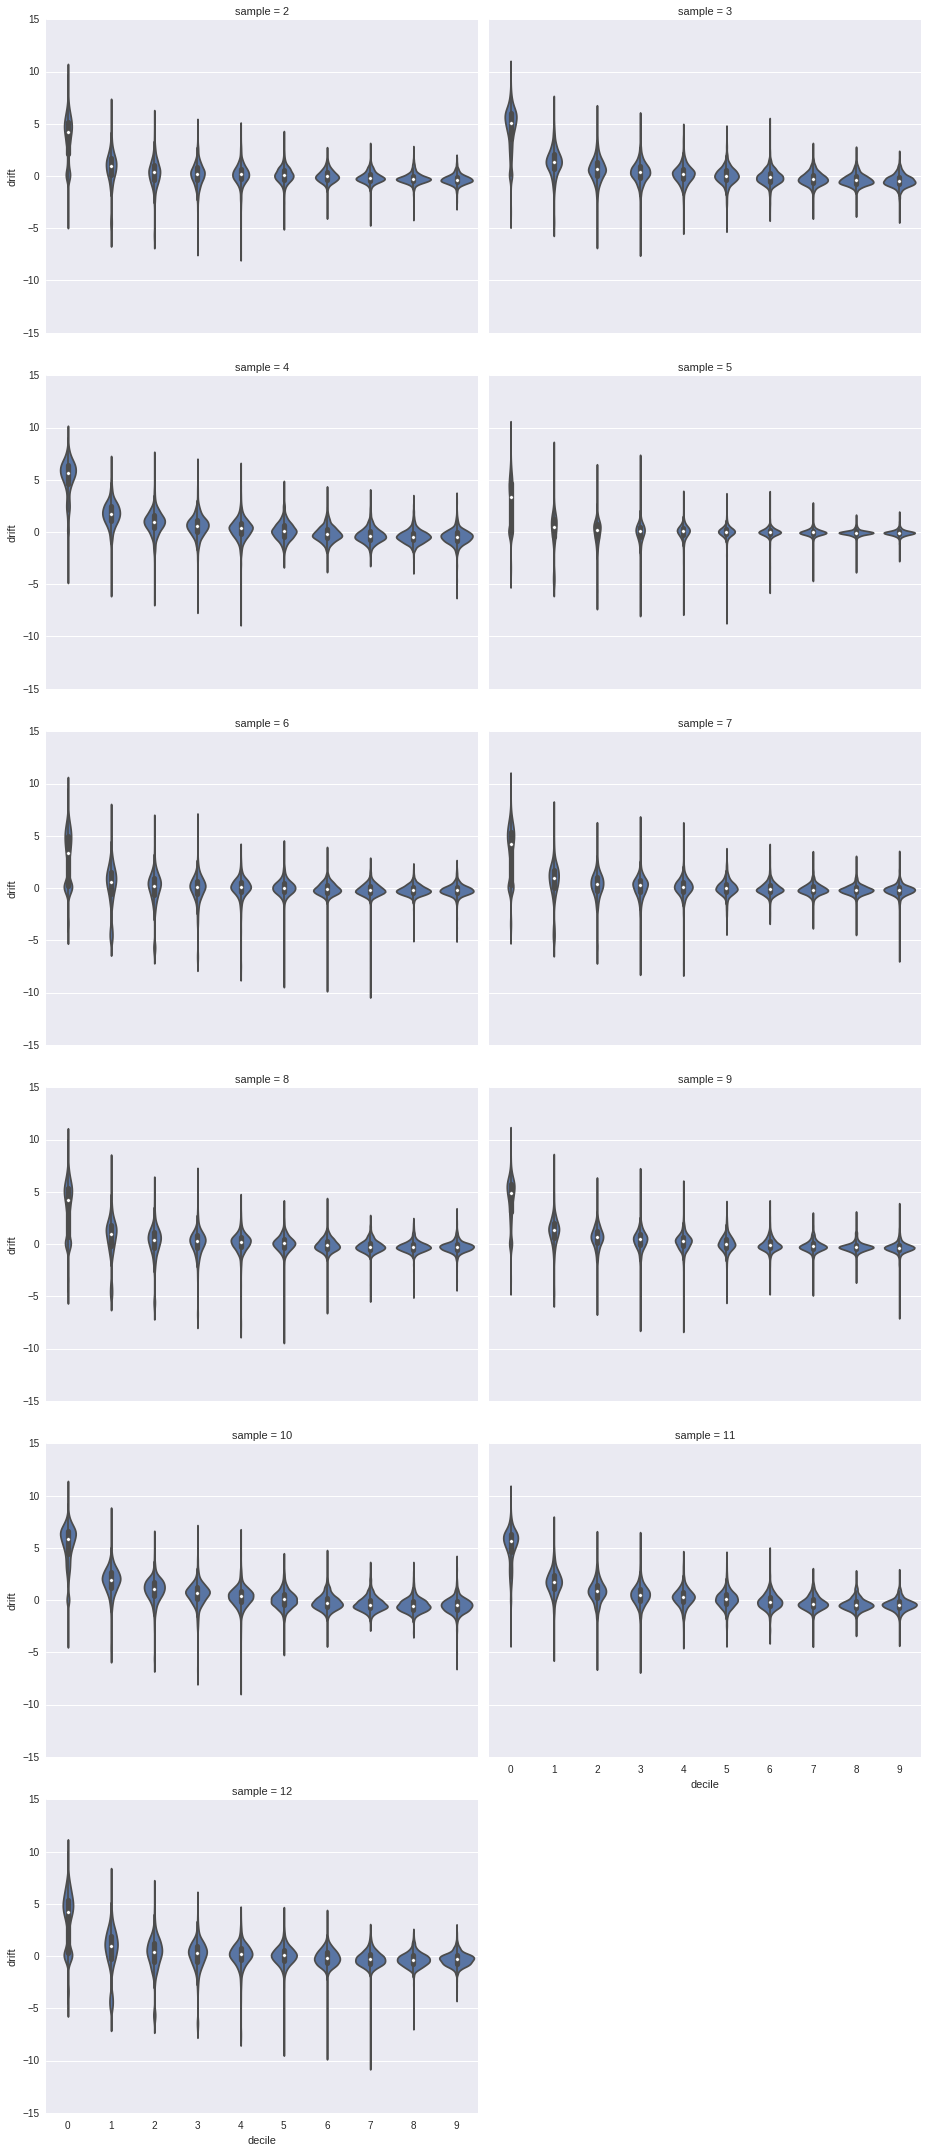

In [31]:
g = sns.FacetGrid(
    full.query("sample != 1"), col = "sample",
    col_wrap = 2, size = 5, aspect = 1.3
)

g.map(sns.violinplot, "decile", "drift")

---

## Drift change over time stratified by decile

In [26]:
full.head()

,wormbaseid,symbol,seqname,cpm_val,sample,day_add_drug,day_harvest_rna,drug_conc_uM,drug_given,log_cpm,ref_log_cpm,drift,exp_percentile,decile
0,WBGene00022521,ZC132.2,ZC132.2,0.000226,1,1,1,0,water,-8.393649,-8.393649,0.0,0.000000,0
1,WBGene00019835,R02F2.6,R02F2.6,0.000228,1,1,1,0,water,-8.386604,-8.386604,0.0,0.005217,0
2,WBGene00006011,srx-120,F49C5.2,0.000262,1,1,1,0,water,-8.247548,-8.247548,0.0,0.010434,0
3,WBGene00022884,ZK1248.17,ZK1248.17,0.000275,1,1,1,0,water,-8.199831,-8.199831,0.0,0.015650,0
4,WBGene00005435,srh-227,C35D6.2,0.000298,1,1,1,0,water,-8.116741,-8.116741,0.0,0.023475,0


In [27]:
test = full.query("drug_given == 'water'")

In [33]:
@config_plot
def rofl(**kwargs):    
    ax = sns.tsplot(
        data = test,
        time = "day_harvest_rna",
        value = "drift",
        unit = "wormbaseid",
        condition = "decile",
        ci = [68, 100]
    )
    ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
    return ax

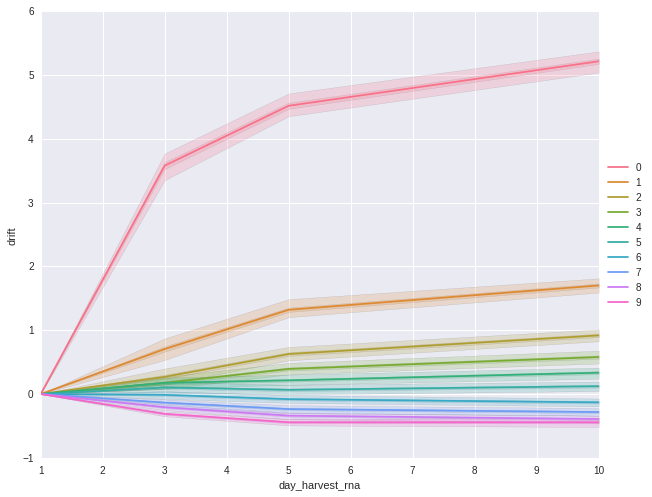

In [34]:
rofl(
    rc = {"figure.figsize": (10, 8)}
)

In [36]:
plot_drift(
    "box", test.query("decile == 0"),
    "day_harvest_rna", "drift", "wormbaseid"
)

ValueError: min() arg is an empty sequence

---

## Drift for water treated worms, all genes (full)

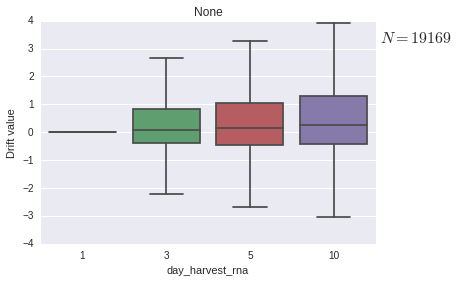

In [22]:
temp = full.query("drug_given == 'water'")

plot_drift(
    "box", temp,
    "day_harvest_rna", "drift", "seqname"
)

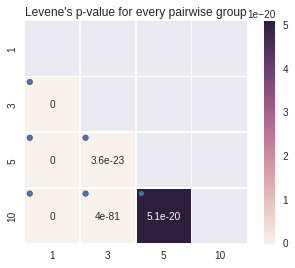

In [23]:
plot_p_val_heatmap(temp, "day_harvest_rna", "drift", circles = True)

## Plot drift for all genes in water treated worms at different days of age (subset)

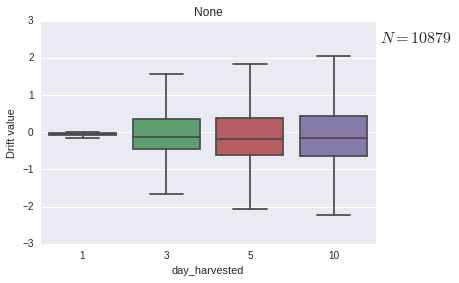

In [24]:
temp = sub.query("drug == 'water'")
                  
plot_drift(
    "box", temp,
    "day_harvested", "trans_drift", "seqname"
)

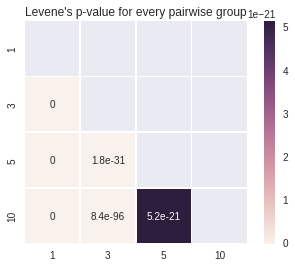

In [25]:
plot_p_val_heatmap(temp, "day_harvested", "trans_drift")

## Effect of mianserin on drift (full transcriptome)

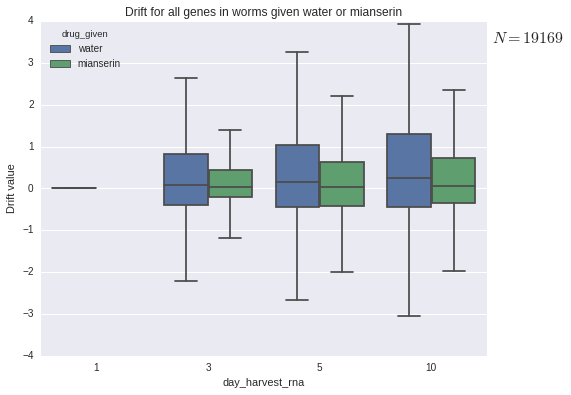

In [26]:
temp = full.query("day_add_drug == 1 & drug_conc_uM in(0, 50)")

plot_drift(
    "box", temp, "day_harvest_rna", "drift", "seqname",
    groupby = "drug_given", rc = {"figure.figsize": (8, 6)},
    title = "Drift for all genes in worms given water or mianserin"
)

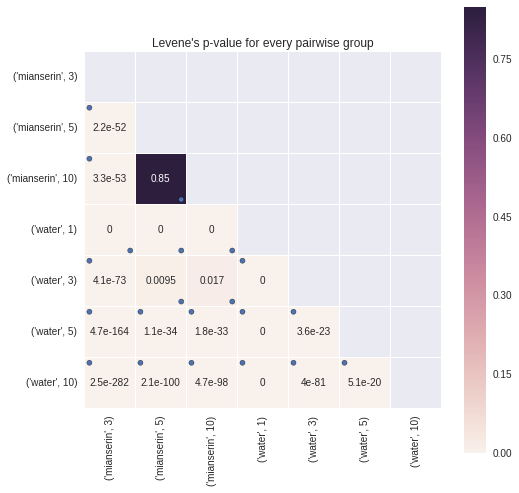

In [27]:
plot_p_val_heatmap(
    temp, ["drug_given", "day_harvest_rna"], "drift",
    rc = {"figure.figsize": (8, 8)}, circles = True
)

## Effect of mianserin on drift (subset)

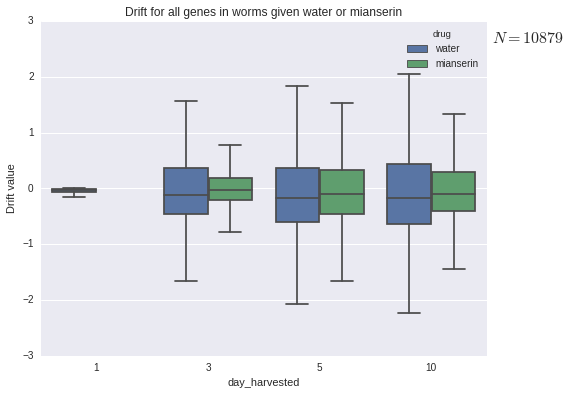

In [28]:
temp = sub.query("day_drug_added == 1 & drug_conc_uM in(0, 50)")

plot_drift(
    "box", temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug", rc = {"figure.figsize": (8, 6)},
    title = "Drift for all genes in worms given water or mianserin"
)

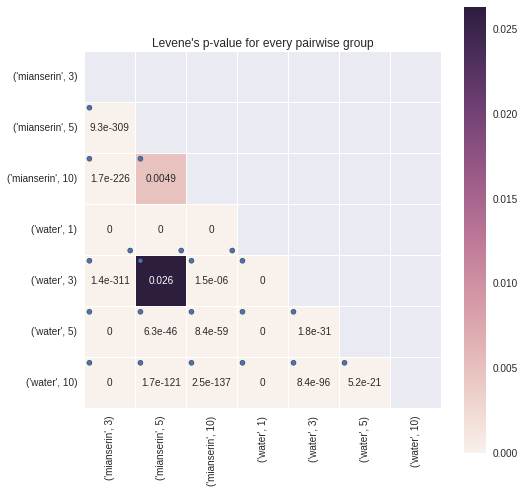

In [29]:
plot_p_val_heatmap(
    temp, ["drug", "day_harvested"], "trans_drift",
    rc = {"figure.figsize": (8, 8)}, circles = True
)